In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import conv_layer
from fastai.vision.data import SegmentationLabelList, SegmentationProcessor, SegmentationItemList
from fastai.vision.transform import get_transforms
from fastai.vision.image import open_image, open_mask, Image
from pathlib import Path
from torch import nn
import torch
import pdb

from spadedata import SpadeItemList, SpadeLabelList

In [3]:
# torch.cuda.empty_cache()

In [4]:
import fastai
print(fastai.__file__, fastai.__version__)

D:\Projects\Spade\fastai\__init__.py 1.0.39


In [5]:
path = Path(r'D:/data/landcover/landcover/')
batch_size = 8

In [6]:
codes = ['NoData', 'Water', 'Wetlands', 'Tree1', 'Shurbland', 'Lowvegetation', 'Barren', 'Structures', 'Impervious',
       'Roads', 'Tree2', 'Tree3', 'Tree4']

In [7]:
 def get_y_func(x, ext='tif'):
    return x.parents[1] / 'images' / (x.stem + '.{}'.format(ext))

## Data Prep

In [8]:
src = (SpadeItemList.from_folder(path/'labels', classes=codes)
      .random_split_by_pct(0.0)
      .label_from_func(get_y_func))

In [9]:
data = (src.transform(get_transforms(max_warp=0), tfm_y=True, size=256)
       .databunch(bs=batch_size))

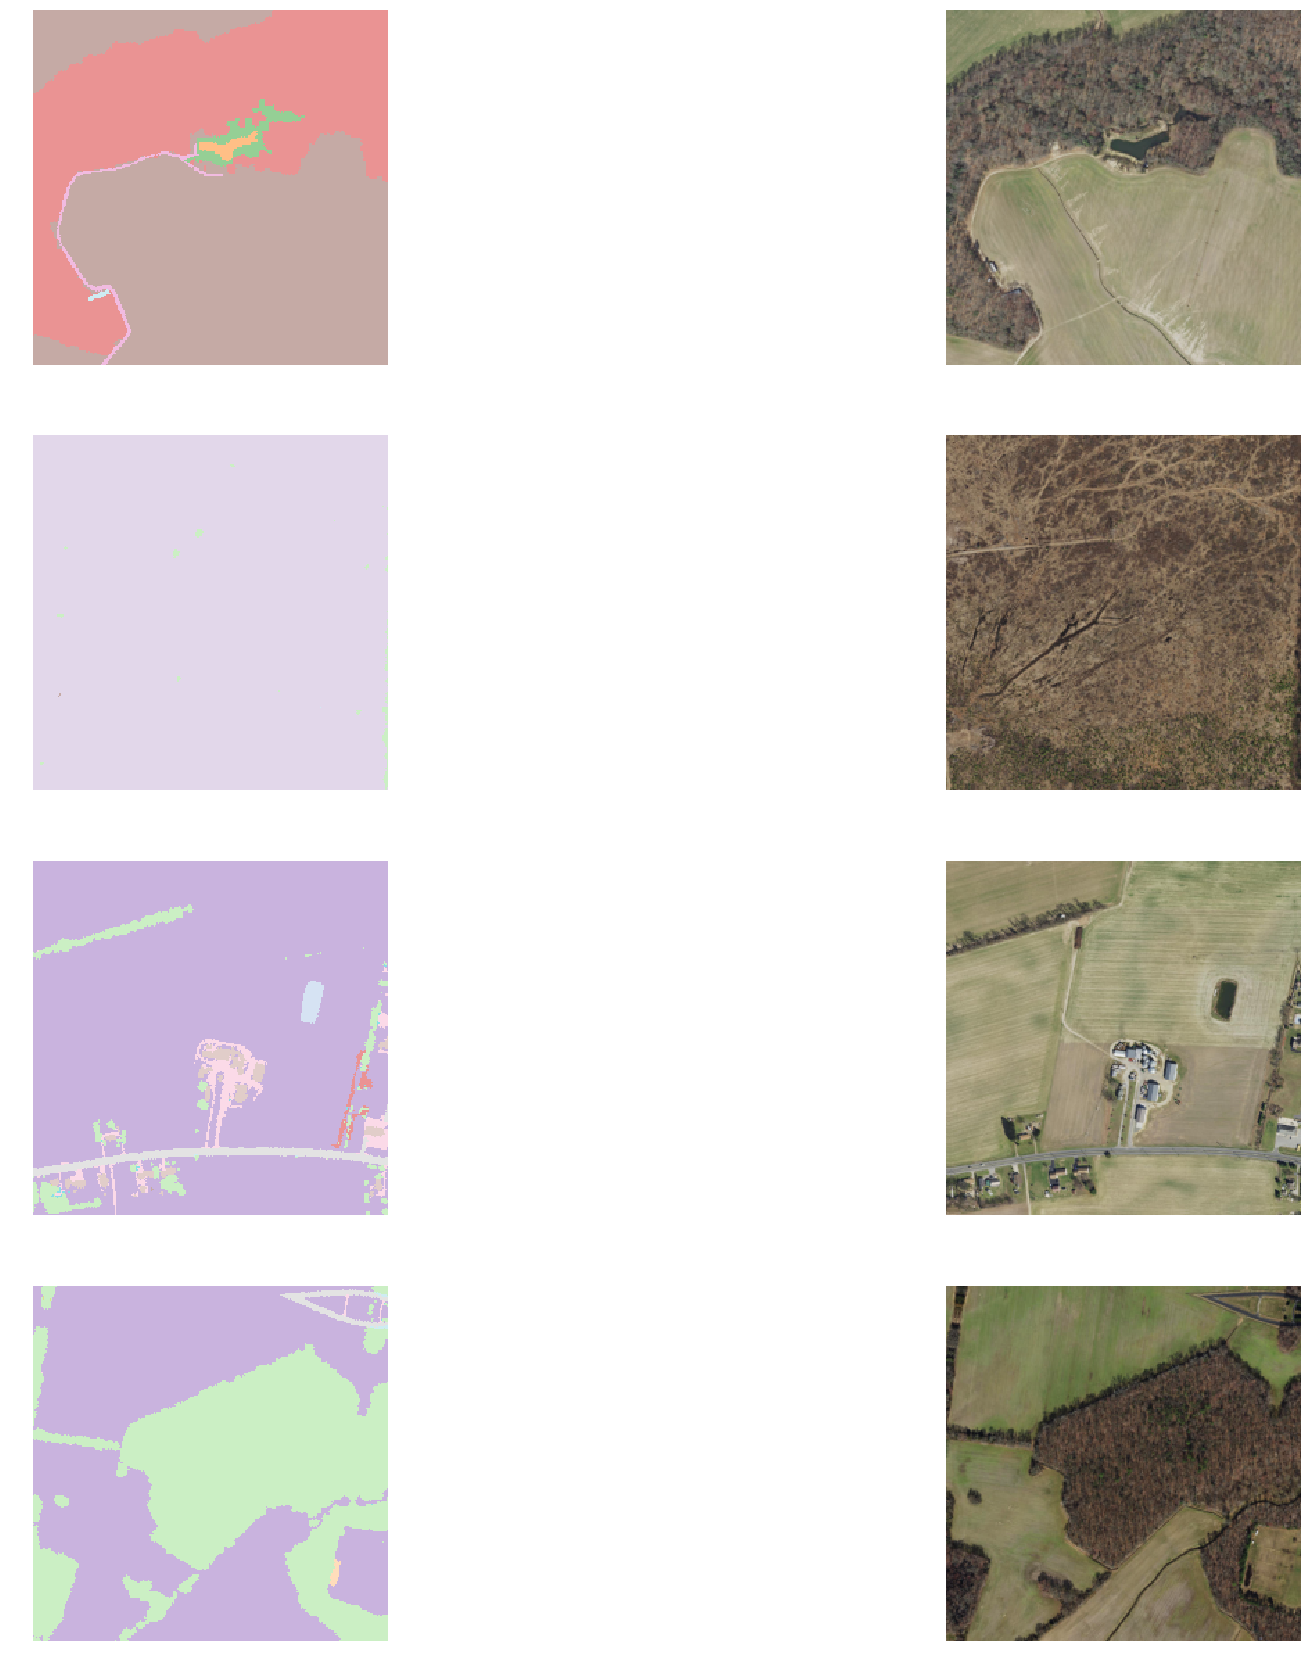

In [10]:
data.show_batch(rows=2)

## Model Architecture

In [10]:
from fastai.vision import ImageSegment, PixelShuffle_ICNR
from fastai.layers import NormType
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torch.distributions import Normal
import torch

In [11]:
device_ = torch.device('cuda')

### Embedding Layer

In [12]:
n_classes = 13
embedding_size = 8

In [13]:
embedding_layer = nn.Embedding(n_classes, embedding_size).to(device_)

### SPADE Block

In [14]:
## check dimension after conv layer
class SpadeBN(nn.Module):
    def __init__(self, nf):
        super(SpadeBN, self).__init__()

        self.bn = nn.BatchNorm2d(nf, affine=False)
        self.conv0 = conv_layer(embedding_size, 128, norm_type=NormType.Spectral)  # hardcoded
        self.conv1 = conv_layer(128, nf, norm_type=NormType.Spectral)
        self.conv2 = conv_layer(128, nf, norm_type=NormType.Spectral)
        
    def forward(self, features, mask):
#         pdb.set_trace()
        size = features.size()[-2:]
        mask = F.interpolate(mask.float(), size=size)
        interim_conv = self.conv0(mask)
        gamma = self.conv1(interim_conv)
        beta = self.conv2(interim_conv)
        return (self.bn(features) * gamma) + beta

###  SPADE ResBlock

In [15]:
class SpadeResBlock(nn.Module):
    def __init__(self, ni, nf):
        super(SpadeResBlock, self).__init__()
        self.spade_bn0 = SpadeBN(ni)
        ## can get away with spectral norm by passing NormType.Spectral
        self.conv0 = conv_layer(ni, nf, use_activ=False, norm_type=NormType.Spectral)
        self.spade_bn1 = SpadeBN(nf)
        self.conv1 = conv_layer(nf, nf, use_activ=False, norm_type=NormType.Spectral)
        self.spade_skip = SpadeBN(ni)
        self.conv_skip = conv_layer(ni, nf, use_activ=False, norm_type=NormType.Spectral, )
        
    def forward(self, features, mask):
        skip_features = self.conv_skip(F.relu(self.spade_skip(features, mask)))
        features = self.conv0(F.relu(self.spade_bn0(features, mask)))
        features = self.conv1(F.relu(self.spade_bn1(features, mask)))
        return skip_features + features

### SpadeGenerator

In [16]:
device_ = torch.device('cuda')

In [17]:
class UpsamplingNearest2d(nn.Module):
    def forward(self, x):
        return F.interpolate(x, scale_factor=2)

In [18]:
# nfs = [1024,1024,1024,512,256,128,64] #orig
nfs = [1024,1024,512,256,128,64]
scale = [2] * len(nfs)
input_noise_dim = 256

class SpadeGenerator(nn.Module):
    
    def __init__(self, input_noise_dim=input_noise_dim,
                 nfs=nfs,
                 pixel_shuffle_upsampling=True,
                 batch_size=batch_size,
                 input_image=None):  ## for semantic style, requires different loss functions
        super(SpadeGenerator, self).__init__()
        self.input_noise_dim = input_noise_dim
        self.batch_size = batch_size
        self.linear = nn.Linear(input_noise_dim, 16384)  # hardcoded
        self.spade_upsample_blocks = nn.ModuleList([])
        for i in range(len(nfs)):
            self.spade_upsample_blocks.append(nn.ModuleList([SpadeResBlock(1024 if i == 0 else nfs[i-1], nfs[i]),
                           PixelShuffle_ICNR(nfs[i], nfs[i], scale=2, norm_type=NormType.Spectral) if pixel_shuffle_upsampling else UpsamplingNearest2d()]))
        self.conv_final = conv_layer(nfs[-1], 3, use_activ=False, bias=True, norm_type=None)
    
    def forward(self, mask):
#         pdb.set_trace()
        
        mask = embedding_layer(mask).squeeze().permute(0, 3, 1, 2)
        gaussian_noise = Normal(0,1).sample(torch.Size([mask.size()[0], self.input_noise_dim])).to(device_).detach()
        linear_features = self.linear(gaussian_noise)
        spatial_features = linear_features.view(self.batch_size, 1024, 4, 4) # hardcoded
        for block in self.spade_upsample_blocks:
            spatial_features = block[0](spatial_features, mask)
            spatial_features = block[1](spatial_features)
#         pdb.set_trace()
        return (torch.tanh(self.conv_final(spatial_features)) + 1)/2

### generator test

In [20]:
test_gen = SpadeGenerator().to(device_)

In [ ]:
inp = torch.randn(8,1,256,256).to(device_)

In [ ]:
x, y = next(iter(data.train_dl))

In [ ]:
from fastai.vision import open_mask, ImageSegment

In [ ]:
x.shape

In [ ]:
ImageSegment(x[0])

In [ ]:
xx = test_gen(x)

In [ ]:
xx

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(xx[1].permute(1,2,0))

In [ ]:
del xx, x, y, test_gen

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from fastai.layers import Lambda

In [ ]:
def AvgFlatten():
    "Takes the average of the input."
    return Lambda(lambda x: x.mean((1,2,3)))#.view(1))

### Perceptual Loss

In [19]:
from torchvision.models import vgg16
from fastai.vision.learner import create_body
from fastai.callbacks.hooks import hook_outputs

In [20]:
vgg16_backbone = create_body(vgg16, pretrained=True, body_fn=lambda x: list(x.children())[0]).to(device_)

In [21]:
vgg16_backbone

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [23]:
USE_PERCEPTUAL_LOSS = True
PERCEPTUAL_LOSS_WEIGHT = 10

class PerceptualLoss(nn.Module):
    def __init__(self, backbone=vgg16_backbone):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg16_backbone
        self.save_feature_idxs = [3, 8, 15, 22, 29] #All layers before a MaxPool.
        self.hooks = hook_outputs([backbone[i] for i in self.save_feature_idxs])
        self.criterion = nn.L1Loss()
        self.weights = [1.0, 1.0/2, 1.0/4, 1.0/2, 1.0] # information from earlier and later layers of the image

    def forward(self, real, fake):
        
#         import pdb
#         pdb.set_trace()
        
        with torch.no_grad():
            self.vgg(real)            
            real_features = [feat.stored for feat in self.hooks]
#             self.remove()
        
        with torch.no_grad():
            self.vgg(fake)
            fake_features = [feat.stored for feat in self.hooks]
#             self.remove()

        loss = 0
        for i in range(len(real_features)):
            loss += self.weights[i] * self.criterion(real_features[i], fake_features[i])        
            
#         self.remove()
        return loss
    
    def remove(self):
        for hook in self.hooks:
            hook.remove()

### Perceptual loss test

In [ ]:
loss_p = PerceptualLoss().to(device_)

In [ ]:
rand = torch.randint(high=100, size=(1, 3, 400, 400)).to(device_).float()

In [ ]:
loss_p(data.y[0].data[None].to(device_), rand)

In [ ]:
loss_p.remove()

### Spade Discriminator

In [24]:
device_ = torch.device('cuda')

In [25]:
disc_nfs = [64,128,256,512]

# USE_FM_LOSS = True
FM_WEIGHT = 10

class SpadeDiscriminator(nn.Module):
    def __init__(self, disc_nfs=disc_nfs):
        super(SpadeDiscriminator, self).__init__()
        self.layers = []
        
        self.conv0 = conv_layer(ni=(3 + embedding_size), nf=64, ks=4, stride=2, bias=True, norm_type=NormType.Spectral, use_activ=False)
        
        self.conv1 = conv_layer(ni=64, nf=128, ks=4, stride=2, bias=True, norm_type=NormType.Spectral, use_activ=False)
        self.in1 = nn.InstanceNorm2d(128)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.conv2 = conv_layer(ni=128, nf=256, ks=4, stride=2, bias=True, norm_type=NormType.Spectral, use_activ=False)
        self.in2 = nn.InstanceNorm2d(256)
        self.conv3 = conv_layer(ni=256, nf=512, ks=4, bias=True, norm_type=NormType.Spectral, use_activ=False)
        self.in3 = nn.InstanceNorm2d(512)         

        ### skipping a layer which seems to be a mistake in the paper.
        self.conv_final = conv_layer(ni=512, nf=1, ks=4, bias=True, norm_type=NormType.Spectral, use_activ=False) #hardcoded
#         self.layers.append(AvgFlatten())
#         self.disc = nn.Sequential(*self.layers)
        
    def forward(self, image, mask, down=2):
#         pdb.set_trace()
        final = torch.zeros(image.shape[0], dtype=image.dtype).to(device_)
        mask = embedding_layer(mask).squeeze().permute(0, 3, 1, 2)
        orig_image  = image.detach()
        
        feat1s = []
        feat2s = []
        feat3s = []
        feat4s = []
        
        for i in range(down + 1):
            if i != 0:
                image = F.avg_pool2d(image, 2, 2) # downsampling
                mask = F.avg_pool2d(mask.type(image.dtype), 2, 2) # downsampling
            
#             print(image.shape, mask.shape)
            inp = torch.cat((image, mask.type(image.dtype)), dim=1)
                    
            feat1 = self.lrelu(self.conv0(inp))# will use these features later
            feat1s.append(feat1)
            
            feat2 = self.lrelu(self.in1(self.conv1(feat1)))
            feat2s.append(feat2)
            
            feat3 = self.lrelu(self.in2(self.conv2(feat2)))
            feat3s.append(feat3)
            
            feat4 = self.lrelu(self.in3(self.conv3(feat3)))            
            feat4s.append(feat4)
            
            final += self.conv_final(feat4).mean(dim=(1,2,3))  # adding all
        
        if USE_PERCEPTUAL_LOSS:
            return final, [feat1s, feat2s, feat3s, feat4s], orig_image
        else:
            return final  ## taking mean/sum
        
        
        

### test disc

In [ ]:
test_disc = SpadeDiscriminator().cuda()

In [ ]:
im = torch.randn(8,3,256,256).cuda()
mask = torch.Tensor(8,1,256,256).cuda()

In [ ]:
test_disc(im, mask, down=2).shape

###  Modify fastai GANLearner

In [26]:
class feature_matching_loss(nn.Module):
    def forward(self, real_feats, fake_feats):
        loss = 0
        for i in range(len(real_feats)):
            for feat_real, feat_fake in zip(real_feats[i], fake_feats[i]):
                loss += F.l1_loss(feat_real, feat_fake) * (4 / 6) / 3 # https://github.com/NVIDIA/pix2pixHD/blob/1c46896fc8b131d36811bbaae357ee6e150d9ea1/models/pix2pixHD_model.py#L187
        return loss        

In [27]:
class GANModule(nn.Module):
    "Wrapper around a `generator` and a `critic` to create a GAN."
    def __init__(self, generator:nn.Module=None, critic:nn.Module=None, gen_mode:bool=False):
        super().__init__()
        self.gen_mode = gen_mode
        if generator: self.generator,self.critic = generator,critic

    def forward(self, *args):
#         pdb.set_trace()
        return self.generator(*args) if self.gen_mode else self.critic(*args)

    def switch(self, gen_mode:bool=None):
        "Put the model in generator mode if `gen_mode`, in critic mode otherwise."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        

In [28]:
PERCEPTUAL_LOSS_WEIGHT = 0.2
FM_WEIGHT = 0.3

class GANLoss(GANModule):
    "Wrapper around `loss_funcC` (for the critic) and `loss_funcG` (for the generator)."
    def __init__(self, loss_funcG, loss_funcC, gan_model:GANModule):
        super().__init__()
        self.loss_funcG,self.loss_funcC,self.gan_model = loss_funcG,loss_funcC,gan_model
     
        if USE_PERCEPTUAL_LOSS:
            self.p_loss = PerceptualLoss()
            self.fm_loss = feature_matching_loss()

    def generator(self, output, target):
        "Evaluate the `output` with the critic then uses `self.loss_funcG` to combine it with `target`."
        fake_pred = self.gan_model.critic(output, target)[0] if USE_PERCEPTUAL_LOSS else self.gan_model.critic(output, target)
        return self.loss_funcG(fake_pred)

    def critic(self, real_pred, input):
        "Create some `fake_pred` with the generator from `input` and compare them to `real_pred` in `self.loss_funcD`."
#         pdb.set_trace()
        if USE_PERCEPTUAL_LOSS:
            real_pred, feats_real, real = real_pred
            
        fake = self.gan_model.generator(input.requires_grad_(False)).requires_grad_(True)
        fake_pred = self.gan_model.critic(fake, input.requires_grad_(False))
        
#         import pdb
#         pdb.set_trace()
        if USE_PERCEPTUAL_LOSS:
            p_loss = PerceptualLoss()
            fake_pred, feats_fake, _ = fake_pred
            perceptual_loss = PERCEPTUAL_LOSS_WEIGHT * self.p_loss(real, fake)
            p_loss.remove()
            fm_loss = FM_WEIGHT * self.fm_loss(feats_real, feats_fake)
#             import pdb
#             pdb.set_trace()
            final_loss = self.loss_funcC(real_pred, fake_pred) + perceptual_loss + fm_loss
        else:
            final_loss = self.loss_funcC(real_pred, fake_pred)

        return final_loss

In [29]:
from fastai.basic_train import LearnerCallback
from fastai.basic_train import Learner
from fastai.callback import SmoothenValue
from functools import partial

def num_children(m:nn.Module)->int:
    "Get number of children modules in `m`."
    return len(list(m.children()))

def requires_grad(m:nn.Module, b=None):
    "If `b` is not set `requires_grad` on all params in `m`, else return `requires_grad` of first param."
    ps = list(m.parameters())
    if not ps: return None
    if b is None: return ps[0].requires_grad
    for p in ps: p.requires_grad=b


flatten_model = lambda m: sum(map(flatten_model,m.children()),[]) if num_children(m) else [m]

class GANTrainer(LearnerCallback):
    "Handles GAN Training."
    _order=-20
    def __init__(self, learn:Learner, switch_eval:bool=False, clip:float=None, beta:float=0.98, gen_first:bool=False,
                 show_img:bool=True, opt_gen=None, opt_critic=None):
#         pdb.set_trace()
        super().__init__(learn)
        self.switch_eval,self.clip,self.beta,self.gen_first,self.show_img = switch_eval,clip,beta,gen_first,show_img
        self.generator,self.critic = self.model.generator,self.model.critic

    def _set_trainable(self):
        train_model = self.generator if     self.gen_mode else self.critic
        loss_model  = self.generator if not self.gen_mode else self.critic
        requires_grad(train_model, True)
        requires_grad(loss_model, False)
        if self.switch_eval:
            train_model.train()
            loss_model.eval()

    def on_train_begin(self, **kwargs):
        "Create the optimizers for the generator and critic if necessary, initialize smootheners."
        if not getattr(self,'opt_gen',None):
            self.opt_gen = self.opt.new([nn.Sequential(*flatten_model(self.generator))])
        else: self.opt_gen.lr,self.opt_gen.wd = self.opt.lr,self.opt.wd
        if not getattr(self,'opt_critic',None):
            self.opt_critic = self.opt.new([nn.Sequential(*flatten_model(self.critic))])
        else: self.opt_critic.lr,self.opt_critic.wd = self.opt.lr,self.opt.wd
        self.gen_mode = self.gen_first
        self.switch(self.gen_mode)
        self.closses,self.glosses = [],[]
        self.smoothenerG,self.smoothenerC = SmoothenValue(self.beta),SmoothenValue(self.beta)
        self.recorder.no_val=True
        self.recorder.add_metric_names(['gen_loss', 'disc_loss'])
        self.imgs,self.titles = [],[]

    def on_train_end(self, **kwargs):
        "Switch in generator mode for showing results."
        self.switch(gen_mode=True)

    def on_batch_begin(self, last_input, last_target, **kwargs):
        "Clamp the weights with `self.clip` if it's not None, return the correct input."
        # set_trace()
        if self.clip is not None:
            for p in self.critic.parameters(): p.data.clamp_(-self.clip, self.clip)
        return ([last_input], last_input) if self.gen_mode else ([last_target, last_input], last_input)

    def on_backward_begin(self, last_loss, last_output, **kwargs):
        "Record `last_loss` in the proper list."
        last_loss = last_loss.detach().cpu()
        if self.gen_mode:
            self.smoothenerG.add_value(last_loss)
            self.glosses.append(self.smoothenerG.smooth)
            self.last_gen = last_output.detach().cpu()
        else:
            self.smoothenerC.add_value(last_loss)
            self.closses.append(self.smoothenerC.smooth)

    def on_epoch_begin(self, epoch, **kwargs):
        "Put the critic or the generator back to eval if necessary."
        self.switch(self.gen_mode)

    def on_epoch_end(self, pbar, epoch, **kwargs):
        "Put the various losses in the recorder and show a sample image."
        self.recorder.add_metrics([getattr(self.smoothenerG,'smooth',None),getattr(self.smoothenerC,'smooth',None)])
        if not hasattr(self, 'last_gen') or not self.show_img: return
        data = self.learn.data
        img = self.last_gen[0]
        norm = getattr(data,'norm',False)
        if norm and norm.keywords.get('do_y',False): img = data.denorm(img)
        img = data.train_ds.y.reconstruct(img)
        self.imgs.append(img)
        self.titles.append(f'Epoch {epoch}')
        pbar.show_imgs(self.imgs, self.titles)

    def switch(self, gen_mode:bool=None):
        "Switch the model, if `gen_mode` is provided, in the desired mode."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        self.opt.opt = self.opt_gen.opt if self.gen_mode else self.opt_critic.opt
        self._set_trainable()
        self.model.switch(gen_mode)
        self.loss_func.switch(gen_mode)

In [30]:
from dataclasses import dataclass
from fastai.basic_train import LearnerCallback

@dataclass
class FixedGANSwitcher(LearnerCallback):
    "Switcher to do `n_crit` iterations of the critic then `n_gen` iterations of the generator."
    n_crit=5
    n_gen=1

    def on_train_begin(self, **kwargs):
        "Initiate the iteration counts."
        self.n_c,self.n_g = 0,0

    def on_batch_end(self, iteration, **kwargs):
        "Switch the model if necessary."
        if self.learn.gan_trainer.gen_mode:
            self.n_g += 1
            n_iter,n_in,n_out = self.n_gen,self.n_c,self.n_g
        else:
            self.n_c += 1
            n_iter,n_in,n_out = self.n_crit,self.n_g,self.n_c
        target = n_iter if isinstance(n_iter, int) else n_iter(n_in)
        if target == n_out:
            self.learn.gan_trainer.switch()
            self.n_c,self.n_g = 0,0

In [31]:
from fastai.basic_train import Learner
from functools import partial
class GANLearner(Learner):
    "A `Learner` suitable for GANs."
    def __init__(self, data, generator:nn.Module, critic:nn.Module, gen_loss_func,
                 crit_loss_func, switcher=None, gen_first:bool=False, switch_eval:bool=True,
                 show_img:bool=True, clip:float=None, opt_gen=None, opt_critic=None, **kwargs):
        gan = GANModule(generator, critic)
        loss_func = GANLoss(gen_loss_func, crit_loss_func, gan)
        switcher = FixedGANSwitcher
        super().__init__(data, gan, loss_func=loss_func, callback_fns=[switcher], **kwargs)
        trainer = GANTrainer(self, clip=clip, switch_eval=switch_eval, show_img=show_img, opt_gen=opt_gen, opt_critic=opt_critic)
        self.gan_trainer = trainer
        self.callbacks.append(trainer)

### Train

In [32]:
from fastai.layers import NoopLoss, Lambda

In [33]:
class disc_loss(nn.Module):
    def forward(self, real, fake):
#         print('disc loss')
        return F.relu(1 - real).mean() + F.relu(1 + fake).mean()

In [34]:
class gen_loss(nn.Module):
    def forward(self, fake):
#         print('gen loss')
        return -1 * fake.mean()

In [35]:
generator = SpadeGenerator()


In [36]:
discriminator = SpadeDiscriminator()

In [37]:
from torch import optim

adam_gen = partial(optim.Adam, lr=1e-4, betas=(0.9,0.99))
adam_disc = partial(optim.Adam, lr=4e-4, betas=(0.9,0.99))

In [38]:
spadegan = GANLearner(data,
                      generator=generator,
                      critic=discriminator,
                      gen_loss_func=gen_loss(),
                      crit_loss_func=disc_loss(),
#                       opt_gen=adam_gen,
#                       opt_critic=adam_disc
                      )

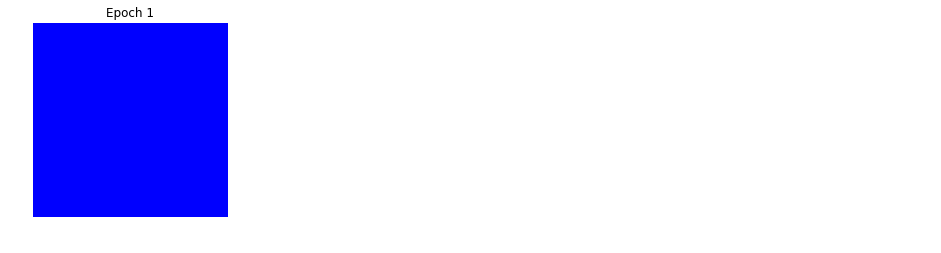

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


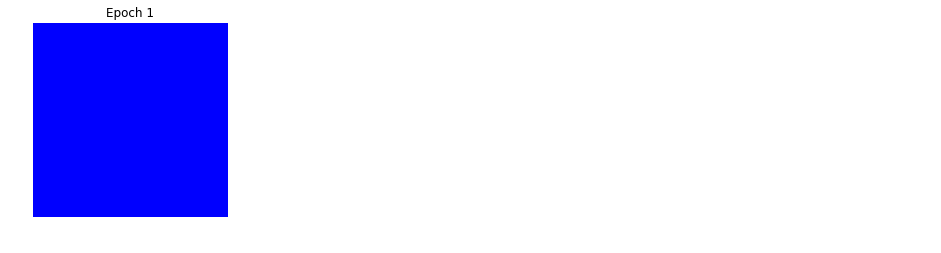

In [53]:
spadegan.lr_find()

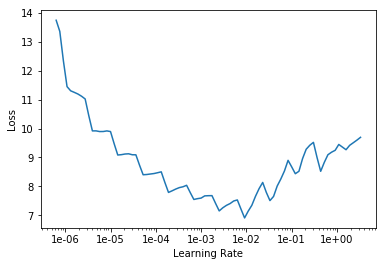

In [54]:
spadegan.recorder.plot()

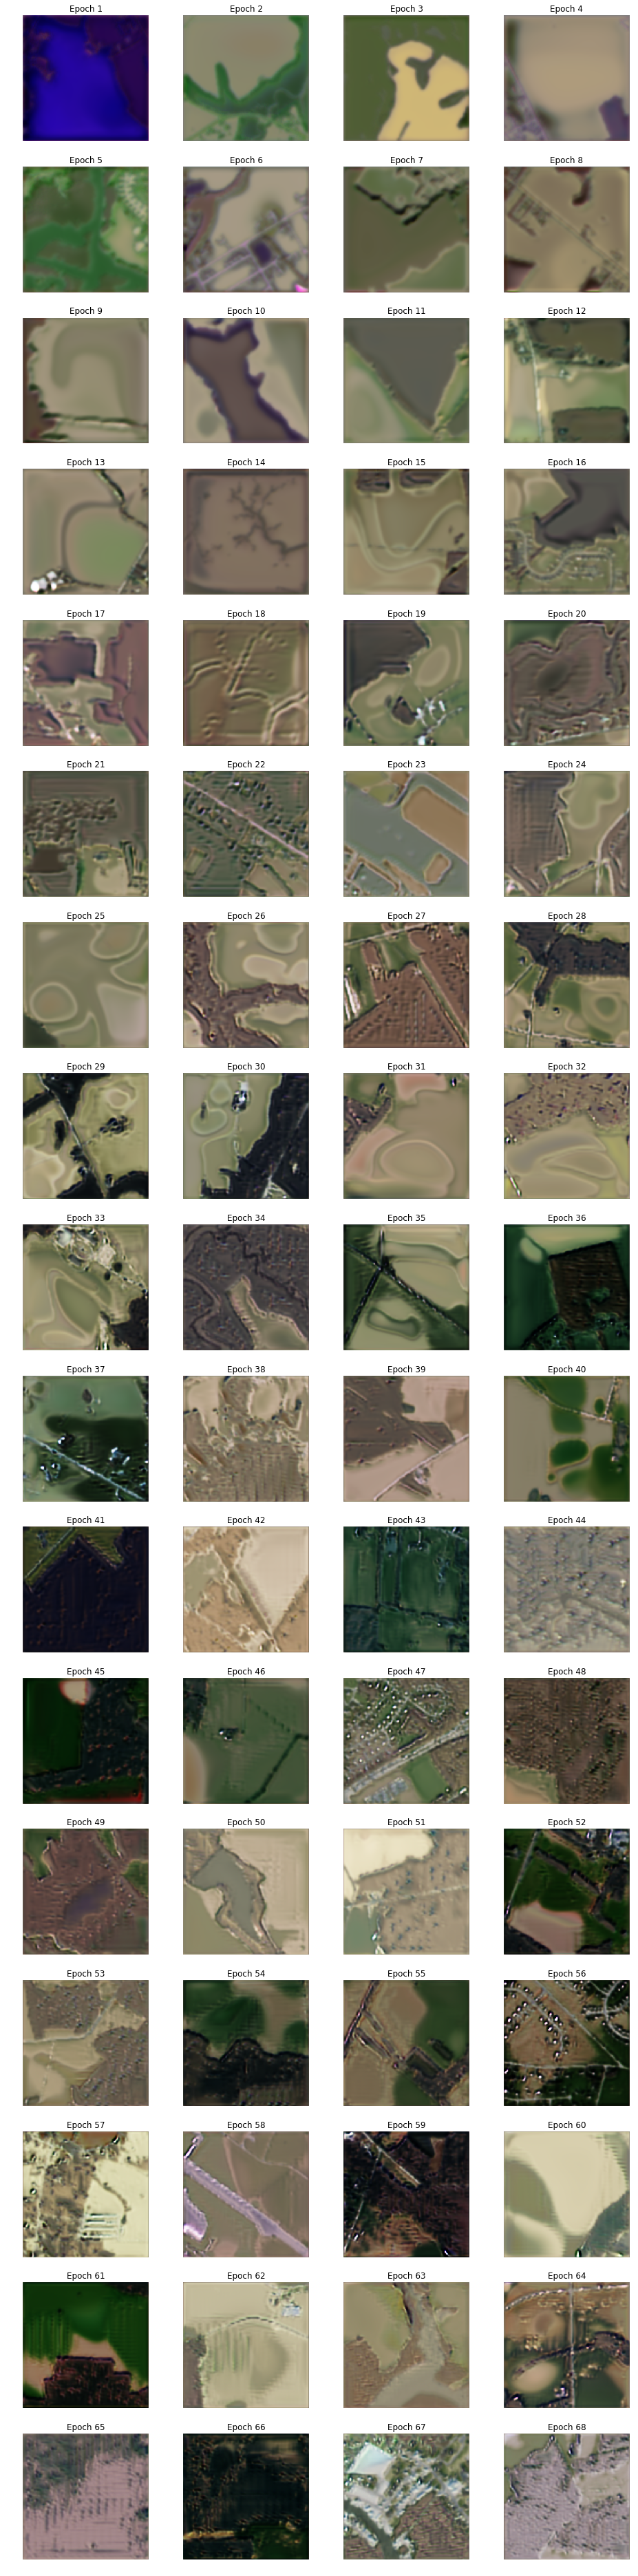

KeyboardInterrupt: 

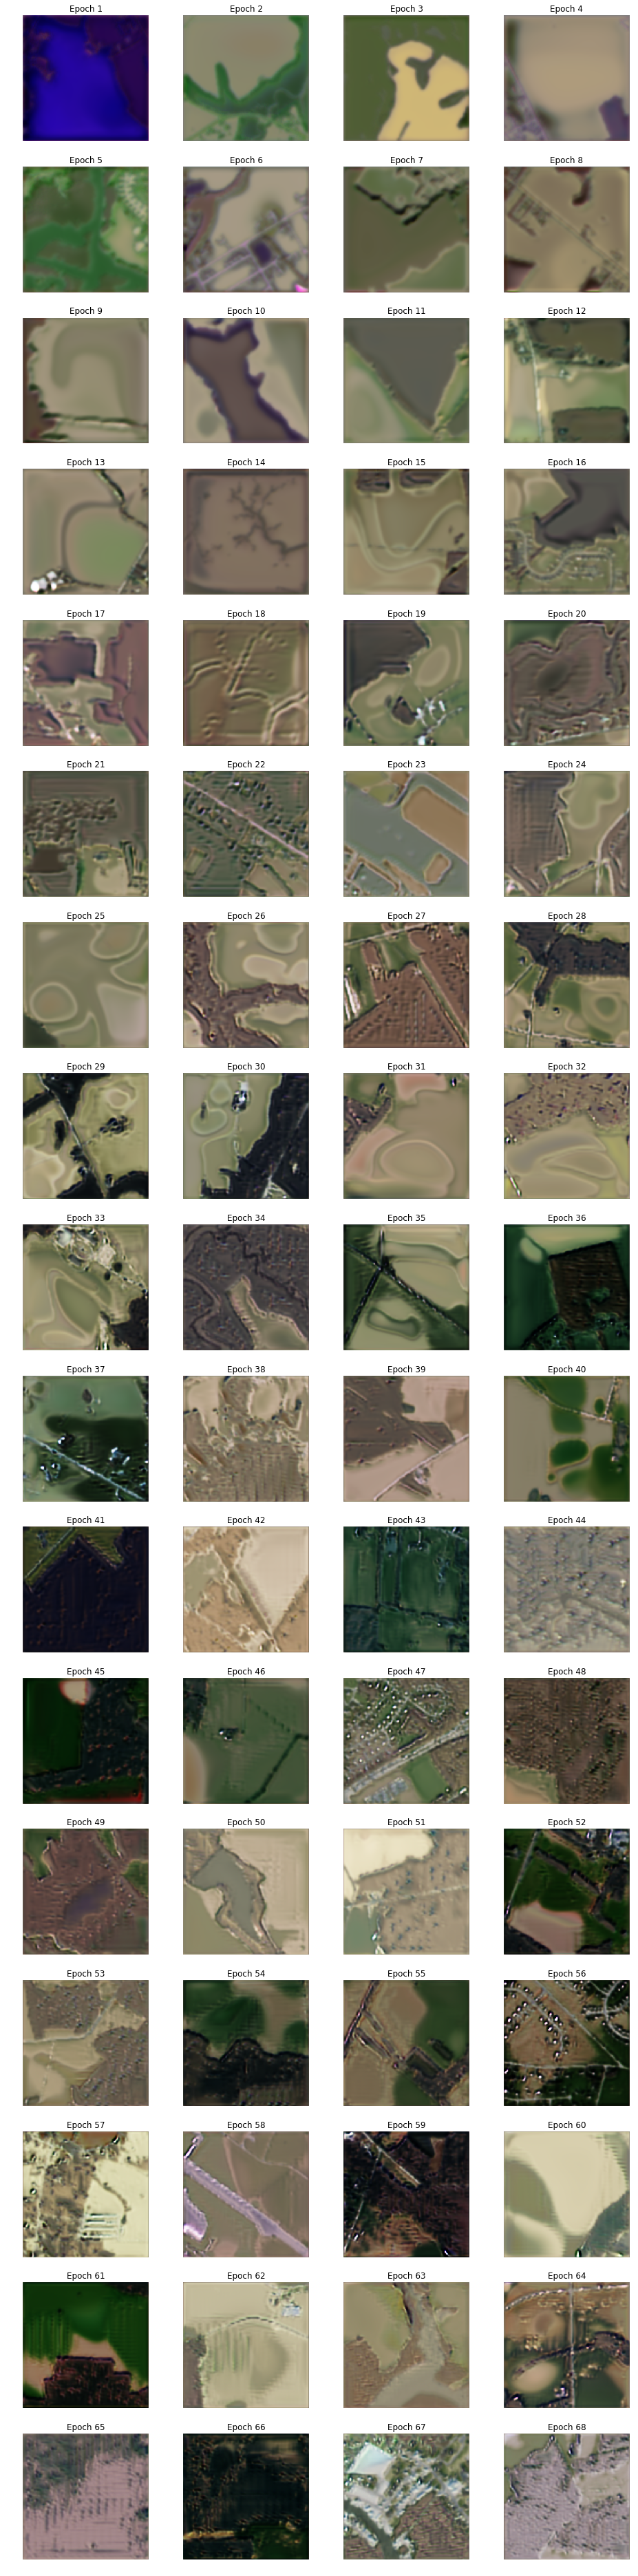

In [39]:
spadegan.fit(epochs=100, lr=slice(1e-4))

In [40]:
spadegan.save('perceptualloss68')

### test generator

In [52]:
spadegan.load('perceptualloss68');

In [70]:
torch.cuda.empty_cache()

In [42]:
spadegan.gan_trainer.switch(gen_mode=True)

In [43]:
x, y = next(iter(data.train_dl))

In [44]:
from fastai.vision import open_mask, ImageSegment

In [45]:
x.shape

torch.Size([8, 1, 256, 256])

In [46]:
idx = 5

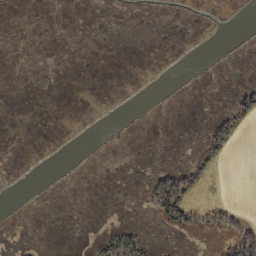

In [47]:
Image(y[idx])

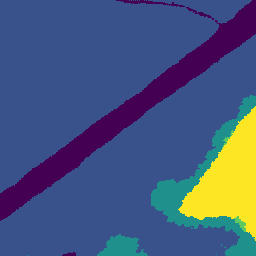

In [48]:
ImageSegment(x[idx])

In [49]:
torch.cuda.empty_cache()

In [50]:
xx = spadegan.gan_trainer.generator(x)

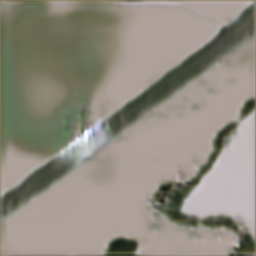

In [51]:
Image(xx[idx].detach())